## Machine Learning

In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from tqdm import tqdm

from anngel.datasets.custom_dataset import CustomDataset

In [2]:
ds = CustomDataset("./tmp", dataset_name='enriched_openbiolink')
input_dir = Path('./4_outputs/small_DS/')
output_dir = Path('./5_outputs/small_DS/')

In [3]:
xy_dir = input_dir / 'XY'
train_dir = xy_dir / 'train'
val_dir = xy_dir / 'val'
test_dir = xy_dir / 'test'

y_train_file = train_dir / 'y.csv'
y_val_file = val_dir / 'y.csv'
y_test_file = test_dir / 'y.csv'

X_train_files = [f for f in train_dir.glob('*.csv') if not f.name == 'y.csv']
X_val_files = [val_dir / f.name for f in X_train_files]
X_test_files = [test_dir / f.name for f in X_train_files]

def calc_metrics(y_pred, y_true):
    return {
        "f1": f1_score(y_pred=y_pred, y_true=y_true),
        "recall": recall_score(y_pred=y_pred, y_true=y_true),
        "precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
        "confusion_matrix": confusion_matrix(y_pred=y_pred, y_true=y_true),
    }

def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    metrics = calc_metrics(y_pred=y_pred, y_true=y)
    cm = metrics["confusion_matrix"]
    metrics["TP"] = cm[0, 0]
    metrics["FP"] = cm[0, 1]
    metrics["FN"] = cm[1, 0]
    metrics["TN"] = cm[1, 1]
    del metrics["confusion_matrix"]
    return metrics


def evaluate(m, X, y, n=100, scale=True):
    y_pred = m.predict(X) > 0
    y_prob_pred = m.predict_proba(X)
    
    order = np.argsort(y_prob_pred)[::-1]
    # print(y_pred[order][:n])
    if scale:
        return y[order][:n].sum() / y.sum()
    else:
        return y[order][:n].sum()
    
def fit_model(
    X_train,
    y_train,
    model,
    parameters,
    scoring=evaluate,
    cv=5,
    **kwargs
):    
    clf = GridSearchCV(model, parameters, scoring=scoring, cv=cv, **kwargs)
    clf.fit(X=X_train, y=y_train)
    return clf

CV = 5
N_JOBS=20

def train_predictor(
    X_train_file, y_train_file,
    out_file,
    cv=CV,
    n_jobs=N_JOBS,
    scoring=evaluate,
):
    m = RandomForestClassifier()
    parameters = dict(
        n_estimators=[100, 250, 500],
        max_depth=[None, 2, 5, 10],
        min_samples_leaf=[1, 32, 128, 256],
        max_features=['sqrt', 1, 2, 4, 8,]
    )

    X_train = pd.read_csv(X_train_file, index_col=0).values
    y_train = pd.read_csv(y_train_file, index_col=0).iloc[:,0].values

    clf = fit_model(
        X_train=X_train,
        y_train=y_train,
        model=m,
        parameters=parameters,
        cv=cv,
        n_jobs=n_jobs,
    )

    with open(out_file, 'wb') as f:
        pickle.dump(clf, f)
    return clf

In [4]:
classifiers_dir = output_dir / 'classifiers_ml'
classifiers_dir.mkdir(exist_ok=True, parents=True)

rerun=False
for X_train_file in tqdm(X_train_files):
    nm = X_train_file.name.split('.')[0]
    out_file = classifiers_dir / f'{nm}.pkl'
    if out_file.exists():
        try:
            # try to load the file
            with open(out_file, 'rb') as f:
                pickle.load(f)
            if not rerun:
                print(out_file, 'exists. Skipping...')
                continue
        except:
            pass

    train_predictor(
        X_train_file=X_train_file,
        y_train_file=y_train_file,
        out_file=out_file,
        cv=CV,
        n_jobs=N_JOBS,
    )

 12%|█▏        | 3/25 [00:00<00:00, 22.86it/s]

5_outputs/small_DS/classifiers_ml/shortest_path_length_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/preferential_attachment_pathway.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/leicht_holme_newman_index_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/shortest_path_length_pathway.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/leicht_holme_newman_index_pathway.pkl exists. Skipping...


 36%|███▌      | 9/25 [00:00<00:00, 22.95it/s]

5_outputs/small_DS/classifiers_ml/preferential_attachment_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/degree_centrality.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/adamic_adar_index_pathway.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/adamic_adar_index_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/clustering.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/in_degree_centrality.pkl exists. Skipping...


 60%|██████    | 15/25 [00:00<00:00, 23.78it/s]

5_outputs/small_DS/classifiers_ml/jaccard_coefficient_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/n_common_neighbors_pathway.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/jaccard_coefficient_pathway.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/average_neighbor_degree.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/n_common_neighbors_disease.pkl exists. Skipping...


 88%|████████▊ | 22/25 [00:00<00:00, 25.48it/s]

5_outputs/small_DS/classifiers_ml/eigenvector_centrality.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/pagerank.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/triangles.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/resource_allocation_index_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/out_degree_centrality.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/resource_allocation_index_pathway.pkl exists. Skipping...


100%|██████████| 25/25 [00:01<00:00, 24.97it/s]

5_outputs/small_DS/classifiers_ml/closeness_centrality.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/personalized_pagerank_disease.pkl exists. Skipping...
5_outputs/small_DS/classifiers_ml/personalized_pagerank_pathway.pkl exists. Skipping...


In [5]:
classifiers_dir = output_dir / 'classifiers_ml'
classifier_paths = list(classifiers_dir.glob('*.pkl'))

probas = {}
val_results = {}
indices = {}
for clf_file in tqdm(classifier_paths):
    with open(clf_file, 'rb') as f:
        clf = pickle.load(f)
    
    nm = clf_file.name.split('.')[0]
    for ds in ('train', 'val', 'test'):
        if probas.get(ds) is None:
            probas[ds] = {}
        X_file = xy_dir / ds / f'{nm}.csv'
        y_file = xy_dir / ds / 'y.csv'
        
        X_df = pd.read_csv(X_file, index_col=0)
        indices[ds] = X_df.index
        X = X_df.values
        y = pd.read_csv(y_file, index_col=0).iloc[:,0].values
        
        probas[ds][nm] = clf.predict_proba(X)
        if ds == 'val':
            y_pred = clf.predict(X)
            val_results[nm] = calc_metrics(y_true=y, y_pred=y_pred)

100%|██████████| 25/25 [02:15<00:00,  5.42s/it]


In [6]:
train_probas_df = pd.DataFrame({nm: v[:,1] for nm, v in probas['train'].items()}, index=indices['train'])
val_probas_df = pd.DataFrame({nm: v[:,1] for nm, v in probas['val'].items()}, index=indices['val'])
test_probas_df = pd.DataFrame({nm: v[:,1] for nm, v in probas['test'].items()}, index=indices['test'])

train_probas_df.to_csv(output_dir / 'train_probabilities.csv')
val_probas_df.to_csv(output_dir / 'val_probabilities.csv')
test_probas_df.to_csv(output_dir / 'test_probabilities.csv')

In [7]:
proba_dfs = {}
Xs = {}
y_dfs = {}
ys = {}
indices={}
for ds in ('train', 'val', 'test'):
    proba_df = pd.read_csv(output_dir / f'{ds}_probabilities.csv', index_col=0)
    proba_dfs[ds] = proba_df
    y_df = pd.read_csv(xy_dir / f'{ds}/y.csv', index_col=0)
    y_dfs[ds] = y_df
    
    X = proba_df.values
    Xs[ds] = X
    y = y_df.iloc[:, 0].values
    ys[ds] = y
    
    indices[ds] = proba_df.index

# lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=(1), max_iter=10000, C=1.0)
lr = LogisticRegression(max_iter=1000)
lr.fit(Xs['train'], ys['train'])
lr.coef_

array([[0.90662089, 0.90546793, 0.90689566, 0.90548934, 0.90492549,
        0.90263681, 0.90663319, 0.90606689, 0.9069169 , 0.47959277,
        0.90573474, 0.90070057, 0.23308322, 0.88253801, 0.90474948,
        0.47960166, 0.47957628, 0.9056932 , 0.90594858, 0.9064729 ,
        0.47964491, 0.90649365, 0.90701018, 0.47955871, 0.90542032]])

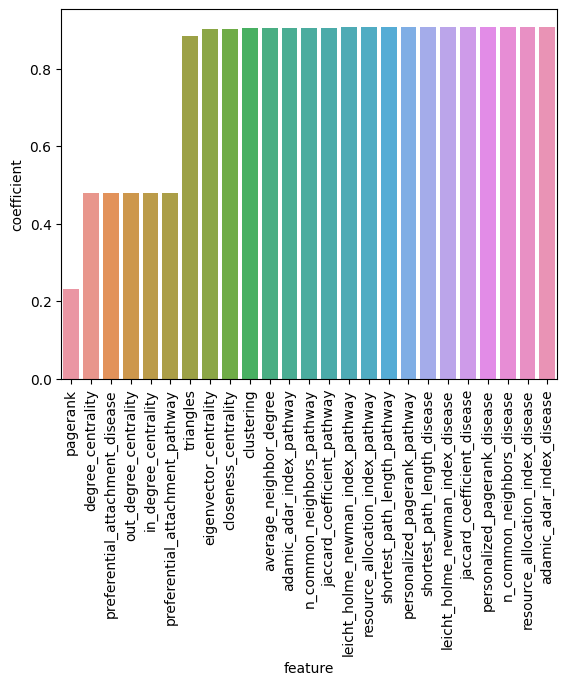

In [8]:
import seaborn as sns
plot_df = pd.DataFrame({'feature': proba_dfs['train'].columns.values, 'coefficient': lr.coef_[0]})
plot_df['coefficient_abs'] = plot_df['coefficient'].abs()

plot = sns.barplot(plot_df.sort_values('coefficient_abs'), x='feature', y='coefficient')
_ = plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=90, )

In [9]:
y_val_pred = lr.predict(Xs['val'])

calc_metrics(y_pred=y_val_pred, y_true=ys['val'])

{'f1': 0.12030075187969924,
 'recall': 0.064,
 'precision': 1.0,
 'confusion_matrix': array([[3862,    0],
        [ 117,    8]])}

In [10]:
y_test_pred = lr.predict(Xs['test'])

metrics = calc_metrics(y_pred=y_test_pred, y_true=ys['test'])
metrics['confusion_matrix']

array([[3863,    0],
       [ 119,    0]])

In [11]:
y_test_prob = lr.predict_proba(Xs['test'])
y_test_pred = lr.predict(Xs['test'])

tmp_df = pd.DataFrame(y_test_prob, index=indices['test'])
tmp_df['irr'] = ys['test']
tmp_df_sorted = tmp_df.sort_values(0, ascending=True)

In [12]:
((y_test_prob[:,1] > 0.5) == y_test_pred).all()

True

In [13]:
ths = np.linspace(0.0, 1.0, 101)

ratios = []
for th in ths:
    idcs = tmp_df_sorted[1] >= th
    ratios.append(tmp_df_sorted[idcs]['irr'].sum() / tmp_df_sorted['irr'].sum())
ratios = np.array(ratios)
    
ratio_df = pd.DataFrame(dict(th=ths, ratio=ratios))

Text(0, 0.5, 'irr_pred / irr_total')

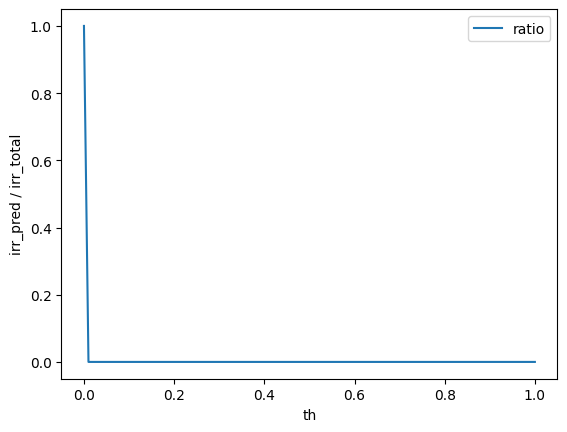

In [14]:
ratio_df.plot(x='th', y='ratio').set_ylabel('irr_pred / irr_total')

In [15]:
ys['test'].sum()

119

In [16]:
n_top = 100

tmp_df_sorted.iloc[:n_top]['irr'].sum()

12

In [17]:
n_top = 10

tmp_df_sorted.iloc[:n_top]['irr'].sum()

4

In [18]:
from anngel.datasets.openbiolink import OpenBioLinkDataset

ds = OpenBioLinkDataset("./tmp/openbiolink/")
nodes_df = ds.get_nodes()

proba_df_all = pd.concat([
    proba_dfs['train'][~proba_dfs['train'].index.duplicated(keep='first')],
    proba_dfs['val'],
    proba_dfs['test'],
]).sort_index()

y_df_all = pd.concat([
    y_dfs['train'][~y_dfs['train'].index.duplicated(keep='first')],
    y_dfs['val'],
    y_dfs['test'],
]).sort_index()

X_all = proba_df_all.values
y_all = y_df_all.values
y_pred_all = lr.predict_proba(X_all)
y_pred_all_df = pd.DataFrame(y_pred_all, index=proba_df_all.index).drop(0, axis=1)
y_pred_all_df.columns = ['probability']

In [19]:
out_df = y_pred_all_df.join(nodes_df, how='left')
out_df = out_df.join(y_df_all)
out_df.sort_values('probability', ascending=False)

,probability,node_id,node_type,irr
114441,0.999942,NCBIGENE:5295,GENE,True
114806,0.999942,NCBIGENE:5468,GENE,True
114441,0.999942,NCBIGENE:5295,GENE,True
114441,0.999942,NCBIGENE:5295,GENE,True
114441,0.999942,NCBIGENE:5295,GENE,True
...,...,...,...,...
113563,0.000043,NCBIGENE:4952,GENE,False
113532,0.000043,NCBIGENE:4935,GENE,False
120205,0.000043,NCBIGENE:8345,GENE,False
108737,0.000043,NCBIGENE:2359,GENE,False


In [20]:
out_df.to_csv(output_dir / 'proba_out_df.csv')